Train a Random Forest Regressor to predict Quantity_Sold using sales and inventory data. 

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [74]:
# Load datasets
df_sales = pd.read_csv("Sales.csv")
df_inventory = pd.read_csv("Inventory.csv")

In [78]:
# Clean Revenue Column (remove '$' and ',')
df_sales["Revenue"] = df_sales["Revenue"].replace({'$': '', ',': ''}, regex=True).astype(float)


In [80]:
# Merge sales with inventory data to get lead time
df = df_sales.merge(df_inventory, on="Product_ID", how="left")


In [82]:
# Feature Selection (Updated)
df = df[["Quantity_Sold", "Revenue", "Quantity_Available", "Reorder_Level"]]

In [84]:
# Outlier Removal using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


In [86]:
# Define Features and Target
X = df.drop(columns=["Quantity_Sold"])
y = df["Quantity_Sold"]

In [88]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [90]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}


In [92]:

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

In [94]:
# Train Best Model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=50,
                      random_state=42)

In [96]:
# Predictions
y_pred = best_model.predict(X_test)


In [98]:
# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [102]:
print(f"Optimized Model Results:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Optimized Model Results:
Mean Absolute Error (MAE): 18.56
Root Mean Squared Error (RMSE): 26.44
R² Score: 0.75


R² Score of 0.75 suggests the model is performing well.

Implementing a Deep Learning model using LSTM (Long Short-Term Memory) in TensorFlow to forecast production lead times based on historical supplier data.


In [ ]:
pip install tensorflow


In [113]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [122]:
# Load Production Orders & Suppliers Data

df_production = pd.read_csv("Production_Orders.csv")
df_suppliers = pd.read_csv("Suppliers.csv")
df_inventory = pd.read_csv("Inventory.csv")

In [182]:
# Convert Order_Date and Completion_Date to datetime format
df_production["Order_Date"] = pd.to_datetime(df_production["Order_Date"])
df_production["Completion_Date"] = pd.to_datetime(df_production["Completion_Date"])

In [184]:
# Compute production delay in days
df_production["Production_Delay_Days"] = (df_production["Completion_Date"] - df_production["Order_Date"]).dt.days
print(df_production)

   Order_ID Product_ID  Quantity_Ordered Order_Date Completion_Date  \
0     PO006     INV006               700 2024-01-22      2024-02-01   
1     PO007     INV007               300 2024-01-25      2024-02-04   
2     PO008     INV008               500 2024-01-28      2024-02-07   
3     PO009     INV009               600 2024-01-30      2024-02-09   
4     PO010     INV010               400 2024-02-02      2024-02-12   
5     PO011     INV011               200 2024-02-04      2024-02-14   
6     PO012     INV012               300 2024-02-06      2024-02-16   
7     PO013     INV013               700 2024-02-08      2024-02-18   
8     PO014     INV014               600 2024-02-10      2024-02-20   
9     PO015     INV015               400 2024-02-12      2024-02-22   
10    PO016     INV016               500 2024-02-14      2024-02-24   
11    PO017     INV017               200 2024-02-16      2024-02-26   
12    PO018     INV018               300 2024-02-18      2024-02-28   
13    

In [190]:
# Merge Production Orders with Inventory (to get Supplier_ID)
df_merged = df_production.merge(df_inventory, on="Product_ID", how="left")

print(df.columns)

# Merge with Suppliers to get Lead Time
df= df_merged.merge(df_suppliers, on="Supplier_ID", how="left")

print(df.columns)

Index(['Order_ID', 'Product_ID', 'Quantity_Ordered', 'Order_Date',
       'Completion_Date', 'Status', 'Production_Delay_Days', 'Product_Name',
       'Quantity_Available', 'Reorder_Level', 'Warehouse_Location',
       'Supplier_ID', 'Supplier_Name', 'Lead_Time_Days', 'Quality_Rating',
       'Location', 'Material_Type'],
      dtype='object')
Index(['Order_ID', 'Product_ID', 'Quantity_Ordered', 'Order_Date',
       'Completion_Date', 'Status', 'Production_Delay_Days', 'Product_Name',
       'Quantity_Available', 'Reorder_Level', 'Warehouse_Location',
       'Supplier_ID', 'Supplier_Name', 'Lead_Time_Days', 'Quality_Rating',
       'Location', 'Material_Type'],
      dtype='object')


In [192]:
# Sort by date for time-series modeling
df = df.sort_values(by="Order_Date")


In [194]:
# Drop missing values
df.dropna(inplace=True)


In [196]:
# Select relevant features
df = df[["Supplier_ID", "Supplier_Name", "Lead_Time_Days", "Production_Delay_Days", "Quantity_Ordered", "Order_Date"]]


In [200]:
# Define features (X) and target variable (y)
X = df[["Lead_Time_Days", "Quantity_Ordered"]].values
y = df["Production_Delay_Days"].values

In [202]:
# Normalize data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [204]:
 #Reshape data for LSTM (samples, time steps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))


In [206]:
# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [214]:
# Build LSTM model
model = Sequential([ LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [216]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [218]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 98.5558 - mae: 9.9101 - val_loss: 91.4213 - val_mae: 9.5485
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 98.4163 - mae: 9.9031 - val_loss: 91.2843 - val_mae: 9.5414
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 97.6394 - mae: 9.8649 - val_loss: 91.1390 - val_mae: 9.5338
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 98.8969 - mae: 9.9267 - val_loss: 90.9827 - val_mae: 9.5256
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 97.8064 - mae: 9.8720 - val_loss: 90.8190 - val_mae: 9.5170
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 97.7774 - mae: 9.8700 - val_loss: 90.6448 - val_mae: 9.5079
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 97.4225 - mae: 9.8540 - val_loss: 90.4579 - val_mae: 9.4981
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 97.5790 - mae: 9.8586 - val_loss: 90.2575 - val_mae: 9.4875
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 97.3447

Loss (MSE) decreases over time → Model is learning.
MAE (Mean Absolute Error) improves → Predictions become more accurate.
Validation performance stabilizes → Indicates model generalization.


In [222]:
# Predict on test set
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


In [230]:
# Convert predictions back to original scale (if needed)
y_pred = y_pred.flatten()

In [226]:
# Compare actual vs predicted values
df_results = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
print(df_results.head())


   Actual  Predicted
0       9   4.792273
1      10  12.818952
2      10   4.052675
3       9   9.784251
4       9   4.620546


In [228]:
# Model Performance
mae = np.mean(abs(y_pred - y_test))
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 3.651836077372233


This means that on average our LSTM model’s predictions for Production Delay Days are off by approximately 3.65 days from the actual values.

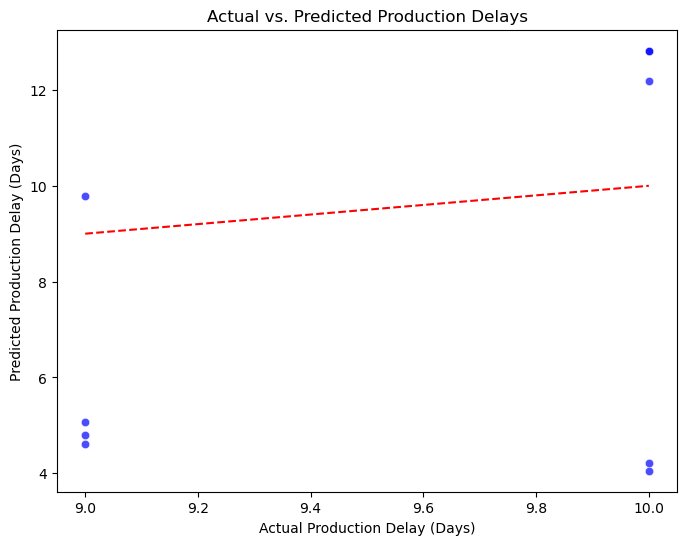

In [238]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color="blue")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Perfect predictions line
plt.xlabel("Actual Production Delay (Days)")
plt.ylabel("Predicted Production Delay (Days)")
plt.title("Actual vs. Predicted Production Delays")
plt.show()


